In [1]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from aux import *

In [2]:
dataset = np.loadtxt("covtype.data", delimiter=",")

In [3]:
print(dataset.shape)

(581012, 55)


In [28]:
train = dataset[:11340]
X_train = train[:, :-1]
y_train = train[:, -1]

In [29]:
val = dataset[11340:11340+3780]
X_val = val[:, :-1]
y_val = val[:, -1]

In [30]:
test = dataset[11340+3780:11340+3780+565892]
X_test = test[:, :-1]
y_test = test[:, -1]

In [31]:
data_preprocess = Pipeline(
    [
        ("VT", VarianceThreshold()),
        ("Scaler", StandardScaler()),
    ]
)

Matriz de correlación pre y post procesado (dígitos)


/usr/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


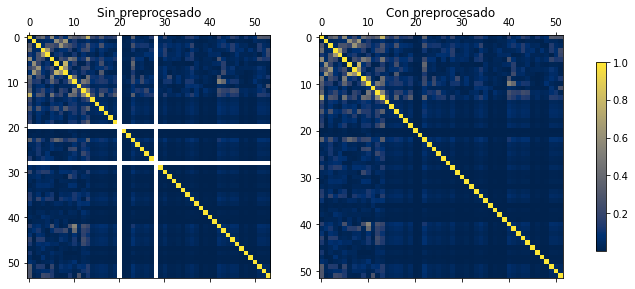

In [32]:
show_preprocess_correlation_matrix(X_train, data_preprocess)

In [33]:
X_train = data_preprocess.fit_transform(X_train, y_train)
X_val = data_preprocess.transform(X_val)
X_test = data_preprocess.transform(X_test)

In [34]:
seed = 6
models = []
models += [
    (
        "Logistic regresion: C={}".format(c),
        LogisticRegression(
            C=c, multi_class="ovr", penalty="l2", max_iter=1000, random_state=seed
        ),
    )
    for c in np.logspace(-2, 2, 3)
]
models += [
    (
        "RidgeClassifier: \u03B1={}".format(a),
        RidgeClassifier(alpha=a, random_state=seed, max_iter=1000),
    )
    for a in np.logspace(-2, 2, 3)
]
models += [
    (
        "Perceptron: \u03B1={}".format(a),
        Perceptron(alpha=a, penalty="l2", random_state=seed, max_iter=1000),
    )
    for a in np.logspace(-7, -3, 3)
]
models += [
    (
        "{}-NN".format(k),
        KNeighborsClassifier(n_neighbors=k)
    )
    for k in [1,2,3]
]
models += [
    (
        "SVM C={}".format(c),
        SVC(C = c)
    )
    for c in np.logspace(-3, 3, 3)
]


# Devolvemos el mejor modelo de entre los considerados
# best_model = kfold_models(models, X_train, y_train, seed, accuracy_score)
best_model = 0
best_model_score = 0
for (name, model) in models:
    print("--> {} <--".format(name))
    model.fit(X_train, y_train)
    val_score = model.score(X_val, y_val)
    print("Validation Score: ", val_score)
    if best_model_score < val_score:
        best_model_score = val_score
        best_model = model

--> Logistic regresion: C=0.01 <--
Validation Score:  0.6698412698412698
--> Logistic regresion: C=1.0 <--
Validation Score:  0.682010582010582
--> Logistic regresion: C=100.0 <--
Validation Score:  0.6814814814814815
--> RidgeClassifier: α=0.01 <--
Validation Score:  0.6370370370370371
--> RidgeClassifier: α=1.0 <--
Validation Score:  0.6370370370370371
--> RidgeClassifier: α=100.0 <--
Validation Score:  0.6349206349206349
--> Perceptron: α=1e-07 <--
Validation Score:  0.5740740740740741
--> Perceptron: α=1e-05 <--
Validation Score:  0.5907407407407408
--> Perceptron: α=0.001 <--
Validation Score:  0.5634920634920635
--> 1-NN <--
Validation Score:  0.7931216931216931
--> 2-NN <--
Validation Score:  0.7761904761904762
--> 3-NN <--
Validation Score:  0.780952380952381
--> SVM C=0.001 <--
Validation Score:  0.587037037037037
--> SVM C=1.0 <--
Validation Score:  0.7343915343915344
--> SVM C=1000.0 <--
Validation Score:  0.8253968253968254


In [35]:
# Entrenamos el mejor modelo en todo el conjunto de datos
print(best_model)
# best_model.fit(X_train, y_train)

SVC(C=1000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [37]:
y_pred = best_model.predict(X_test)
print("Accuracy en test: {:.3f}%".format(100 * accuracy_score(y_test, y_pred)))

Accuracy en test: 70.641%


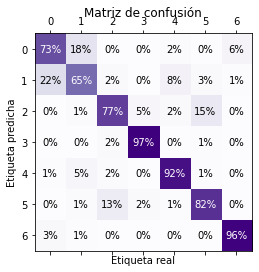

In [43]:
"""Muestra matriz de confusión de la base de datos de dígitos."""
mat = confusion_matrix(y_test, y_pred)
mat = 100 * mat.astype("float64") / mat.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots()
ax.matshow(mat, cmap="Purples")
ax.set(
    title="Matriz de confusión",
    xticks=np.arange(7),
    yticks=np.arange(7),
    xlabel="Etiqueta real",
    ylabel="Etiqueta predicha",
)
for i in range(7):
    for j in range(7):
        ax.text(
            j,
            i,
            "{:.0f}%".format(mat[i, j]),
            ha="center",
            va="center",
            color="black" if mat[i, j] < 50 else "white",
        )

plt.show()